# Ergodic Performance Bounds in Fading Channels with Fixed Rayleigh Fading Marginals

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig

This notebook is part of the paper "Copula-Based Multi-User Performance Bounds - Part I: Theory" ([doi:XXX](https://doi.org/XXX)).  
If you use any of this work, please cite the above paper.

In [1]:
import numpy as np
from scipy import integrate
from scipy.special import expi
from scipy import stats
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

from expectation_bounds import lower_sum_rate, upper_sum_rate, indep_sum_rate

# Scenario

$\color{red}{TODO}$
We consider a channel with fading and interference: Alice wants to transmit a message to Bob over a channel with gain $X$. At the same time, another user transmits which causes interference modeled by $Y$.

This gives the following expressions of the signal-to-interference-plus-noise ratio (SINR) and capacity:
$$\text{SINR}=\rho({X}, {Y}) = \frac{{X}}{s + {Y}}$$
$$R(X, Y) = \log_2\left(1 + \rho(X, Y)\right) = \log_2\left(1 + \frac{X}{s + Y}\right)$$

The signal-to-noise ratio (SNR) is given as $\text{SNR}=1/s$.

In the following, we will consider the case of Rayleigh fading. The receive signals $X$ and $Y$ are therefore exponentially distributed, i.e., $X\sim\exp(\lambda_{x})$, $Y\sim\exp(\lambda_{y})$.


# Results

In the following, the upper and lower bound on both the expected SINR and capacity are presented. For comparison, the independent case is also given.
The derivations can be found in $\color{red}{\text{add link to paper}}$.

# Sum Rate

Text about the sum rate.

$$R_{\text{Sum}} = \log_2\left(1 + \rho_{x}X + \rho_{y}Y\right)$$

In [2]:
def calc_sum_rate(snr_db, bound='min', lam_x=1, lam_y=1):
    snr_lin = 10**(snr_db/10.)
    #s = 1./snr_lin
    if bound.startswith('ind'):
        return indep_sum_rate(lam_x=lam_x, lam_y=lam_y, snr_x=snr_lin, snr_y=snr_lin)
    elif bound.startswith('min') or bound.startswith('low'):
        return lower_sum_rate(lam_x=lam_x, lam_y=lam_y, snr_x=snr_lin, snr_y=snr_lin)
    elif bound.startswith('max') or bound.startswith('up'):
        return upper_sum_rate(lam_x=lam_x, lam_y=lam_y, snr_x=snr_lin, snr_y=snr_lin)
    else:
        return NotImplemented

In [3]:
def capacity_plot():
    fig, ax = plt.subplots(num="Ergodic Sum Rate")
    ax.set_xlabel("SNR $\\rho_{x}=\\rho_{y}$ [dB]")
    ax.set_ylabel("Ergodic Sum Rate")
    ax.set_ylim([0, 3])
    plots = {}
    snr_db = np.arange(-5, 6)
    keys = ['min', 'max', 'ind']
    #keys = ['min']
    for _key in keys:
        plots[_key] = ax.plot(snr_db, np.zeros(len(snr_db)), 'o-', label=_key)[0]
    fig.legend()
    
    def update_plot(lam_x=1, lam_y=1):
        for _key, _plot in plots.items():
            _plot.set_ydata(calc_sum_rate(snr_db, _key, lam_x=lam_x, lam_y=lam_y))
        fig.canvas.draw_idle()
    
    interact(update_plot, lam_x=(.1, 3., .1), lam_y=(.25, 5., .25))

<IPython.core.display.Javascript object>


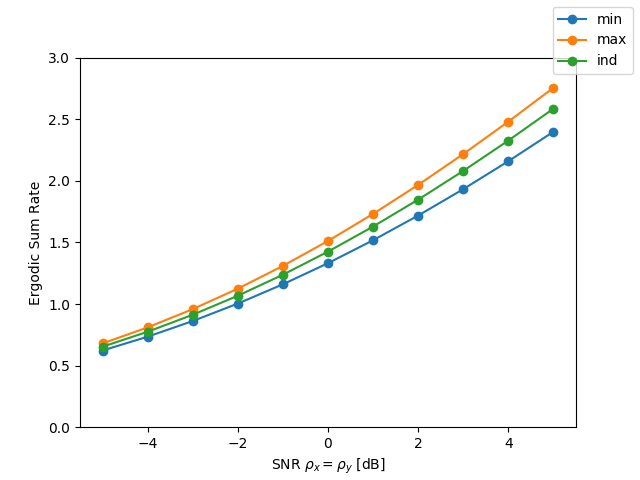

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [4]:
capacity_plot()

In [5]:
def sinr(x, y, s=1):
    return x/(s+y)

def capacity(x, y, s=1):
    return np.log2(1 + x/(s+y))

In [6]:
def independent_sinr(s=1, lam_x=1, lam_y=1):
    expect_x = 1/lam_x
    expect_z = lam_y*np.exp(lam_y*s)*(-expi(-lam_y*s))  # for real x>0: Gamma(0, x)=-Ei(-x)
    return expect_x*expect_z

def independent_capacity(s=1, lam_x=1, lam_y=1):
    if lam_x == lam_y:
        lam = lam_x
        expect_xi = 1 + np.exp(lam*s)*(lam*s-1)*expi(-lam*s) + np.log(s)
        expect_psi = -np.exp(lam*s)*(expi(-lam*s)-np.exp(-lam*s)*np.log(s))
    else:
        expect_xi = -(np.exp(lam_x*s)*lam_y*expi(-lam_x*s)-np.exp(lam_y*s)*lam_x*expi(-lam_y*s)+np.log(s)*(lam_x-lam_y))/(lam_y-lam_x)
        expect_psi = -np.exp(lam_y*s)*(expi(-lam_y*s)-np.exp(-lam_y*s)*np.log(s))
    return (expect_xi - expect_psi)/np.log(2)

In [7]:
def lower_sinr(s=1, lam_x=1, lam_y=1):
    return (lam_y + lam_y**2*s*np.exp(lam_y*s)*expi(-lam_y*s))/lam_x

def lower_capacity(s=1, lam_x=1, lam_y=1):
    _part1 = np.exp(lam_y*s)*expi(-lam_y*s)
    _part2 = np.exp((lam_y*lam_x*s)/(lam_x+lam_y))*expi(-lam_x*lam_y*s/(lam_x+lam_y))
    return (_part1 - _part2)/np.log(2)

In [8]:
def inv_cdf(u, lam=1):
    return -np.log(1-u)/lam

def calc_expected(func, snr_db, bound='min', lam_x=1, lam_y=1):
    snr_lin = 10**(snr_db/10.)
    s = 1./snr_lin
    if bound.startswith('ind'):
        if func == sinr:
            return independent_sinr(s=s, lam_x=lam_x, lam_y=lam_y)
        elif func == capacity:
            return independent_capacity(s=s, lam_x=lam_x, lam_y=lam_y)
    elif bound.startswith('min') or bound.startswith('low'):
        if func == sinr:
            return lower_sinr(s=s, lam_x=lam_x, lam_y=lam_y)
        elif func == capacity:
            return lower_capacity(s=s, lam_x=lam_x, lam_y=lam_y)
    elif bound.startswith('max') or bound.startswith('up'):
        def cost_func(u, s=1, lam_x=1, lam_y=1):
            if bound.startswith('max'):
                _u = 1.-u
            return func(inv_cdf(u, lam=lam_x), inv_cdf(_u, lam=lam_y), s=s)
        expected = integrate.quad(cost_func, 0, 1, args=(s,lam_x, lam_y))
        return expected[0]
    else:
        return NotImplemented

<IPython.core.display.Javascript object>


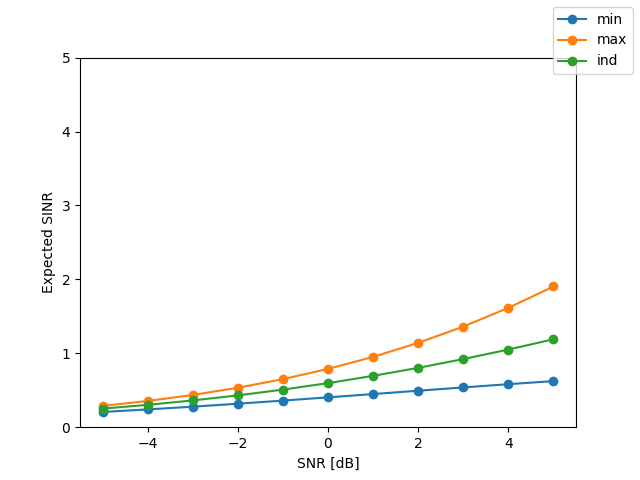

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [9]:
def sinr_plot():
    fig, ax = plt.subplots(num="Expected SINR")
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Expected SINR")
    ax.set_ylim([0, 5])
    plots = {}
    snr_db = np.arange(-5, 6)
    keys = ['min', 'max', 'ind']
    for _key in keys:
        results = [calc_expected(sinr, snr, _key) for snr in snr_db]
        plots[_key] = ax.plot(snr_db, results, 'o-', label=_key)[0]
    fig.legend()
    
    def update_plot(lam_x=1, lam_y=1):
        for _key, _plot in plots.items():
            _plot.set_ydata([calc_expected(sinr, snr, _key, lam_x=lam_x, lam_y=lam_y) for snr in snr_db])
        fig.canvas.draw_idle()
    
    interact(update_plot, lam_x=(.1, 3, .1), lam_y=(.25, 5., .25))

sinr_plot()

<IPython.core.display.Javascript object>


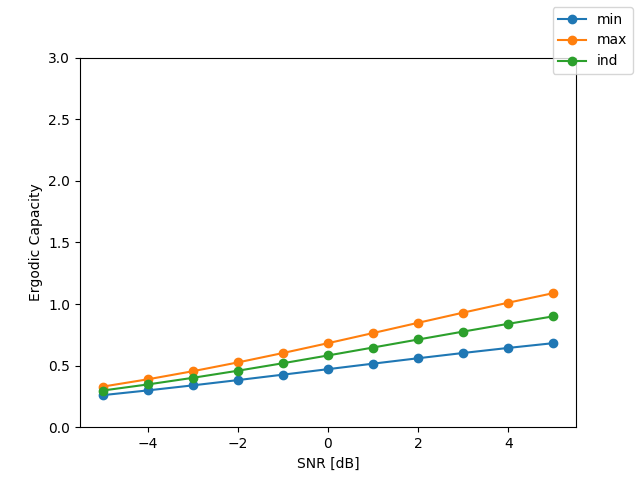

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [10]:
def capacity_plot():
    fig, ax = plt.subplots(num="Ergodic Capacity")
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Ergodic Capacity")
    ax.set_ylim([0, 3])
    plots = {}
    snr_db = np.arange(-5, 6)
    keys = ['min', 'max', 'ind']
    for _key in keys:
        results = [calc_expected(capacity, snr, _key) for snr in snr_db]
        plots[_key] = ax.plot(snr_db, results, 'o-', label=_key)[0]
    fig.legend()
    
    def update_plot(lam_x=1, lam_y=1):
        for _key, _plot in plots.items():
            _plot.set_ydata([calc_expected(capacity, snr, _key, lam_x=lam_x, lam_y=lam_y) for snr in snr_db])
        fig.canvas.draw_idle()
    
    interact(update_plot, lam_x=(.1, 3., .1), lam_y=(.25, 5., .25))

capacity_plot()

# Optimal Distributions

The optimal distributions are given by comonotonic and counter-monotonic variables for the lower and upper bound, respectively.

In the following, the joint PDFs for these cases are shown by using Monte Carlo simulations.

<IPython.core.display.Javascript object>


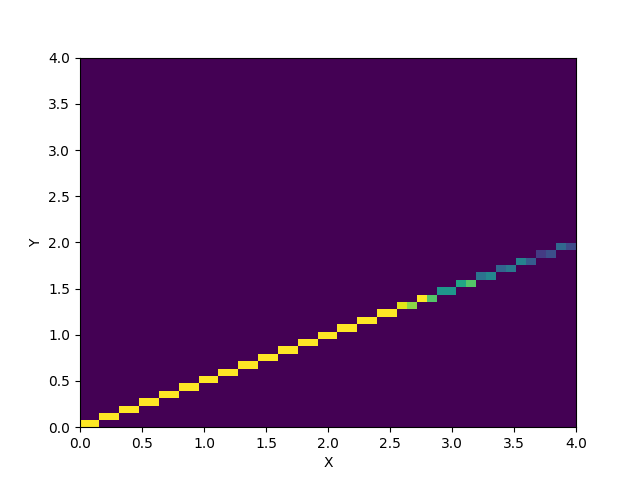

interactive(children=(Dropdown(description='bound', options=('min', 'max', 'ind'), value='min'), FloatSlider(v…

In [11]:
def joint_dist(bound=["min", "max", "ind"], lam_x=1., lam_y=2.):
    fig, ax = plt.subplots(num="Optimal Distribution")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    N = 10000
    u = np.random.rand(N)
    u_y = np.random.rand(N)
    
    def update_plot(bound, lam_x=lam_x, lam_y=lam_y):
        x = inv_cdf(u, lam=lam_x)
        if bound.startswith('min') or bound.startswith('low'):
            y = inv_cdf(u, lam=lam_y)
        elif bound.startswith('max') or bound.startswith('up'):
            y = inv_cdf(1-u, lam=lam_y)
        elif bound.startswith("ind"):
            y = inv_cdf(u_y, lam=lam_y)
        plt.hist2d(x, y, bins=50, range=[[0,4], [0,4]], density=True, vmin=0, vmax=1)
        fig.canvas.draw_idle()
    
    interact(update_plot, bound=["min", "max", "ind"], lam_x=(.25, 2, .25), lam_y=(.5, 3, .25))

joint_dist("max")